In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os

print ("tensorflow version: ",tf.__version__)
print("is using gpu: ", len(tf.config.list_physical_devices('GPU')) > 0) # Changed this line to use the correct function


tensorflow version:  2.17.1
is using gpu:  True


## **Load Data**

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


array([[[154, 177, 187],
        [126, 137, 136],
        [105, 104,  95],
        ...,
        [ 91,  95,  71],
        [ 87,  90,  71],
        [ 79,  81,  70]],

       [[140, 160, 169],
        [145, 153, 154],
        [125, 125, 118],
        ...,
        [ 96,  99,  78],
        [ 77,  80,  62],
        [ 71,  73,  61]],

       [[140, 155, 164],
        [139, 146, 149],
        [115, 115, 112],
        ...,
        [ 79,  82,  64],
        [ 68,  70,  55],
        [ 67,  69,  55]],

       ...,

       [[175, 167, 166],
        [156, 154, 160],
        [154, 160, 170],
        ...,
        [ 42,  34,  36],
        [ 61,  53,  57],
        [ 93,  83,  91]],

       [[165, 154, 128],
        [156, 152, 130],
        [159, 161, 142],
        ...,
        [103,  93,  96],
        [123, 114, 120],
        [131, 121, 131]],

       [[163, 148, 120],
        [158, 148, 122],
        [163, 156, 133],
        ...,
        [143, 133, 139],
        [143, 134, 142],
        [143, 133, 144]]], dtype=uint8)
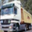

In [4]:
x_train[1,:]

## **Normalize Values**

In [5]:
x_train = x_train/255.0
x_test = x_test/255.0

## **Reshape Data**

In [6]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [7]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [8]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

## **Show Data**

<function matplotlib.pyplot.show(close=None, block=None)>

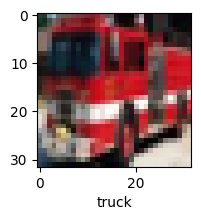

In [9]:
idx = random.randint(0,len(x_train))
plt.figure(figsize = (15,2))
plt.imshow(x_train[idx,:])
plt.xlabel(classes[y_train[idx]])
plt.show


# **Build Model**

In [10]:
from tensorflow.keras import models, layers

In [25]:
ann = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ann.fit(x_train, y_train, epochs=10)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3045 - loss: 1.9279
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4191 - loss: 1.6461
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4504 - loss: 1.5558
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4710 - loss: 1.4952
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4901 - loss: 1.4422
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5105 - loss: 1.3859
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5262 - loss: 1.3485
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5402 - loss: 1.3137
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5463 - loss: 1.2833
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5579 - loss: 1.2529


In [26]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred = ann.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.42      0.53      1000
           1       0.66      0.57      0.61      1000
           2       0.54      0.15      0.24      1000
           3       0.37      0.34      0.35      1000
           4       0.41      0.45      0.43      1000
           5       0.61      0.20      0.30      1000
           6       0.48      0.68      0.56      1000
           7       0.44      0.71      0.54      1000
           8       0.66      0.57      0.61      1000
           9       0.38      0.78      0.51      1000

    accuracy                           0.49     10000
   macro avg       0.53      0.49      0.47     10000
weighted avg       0.53      0.49      0.47     10000



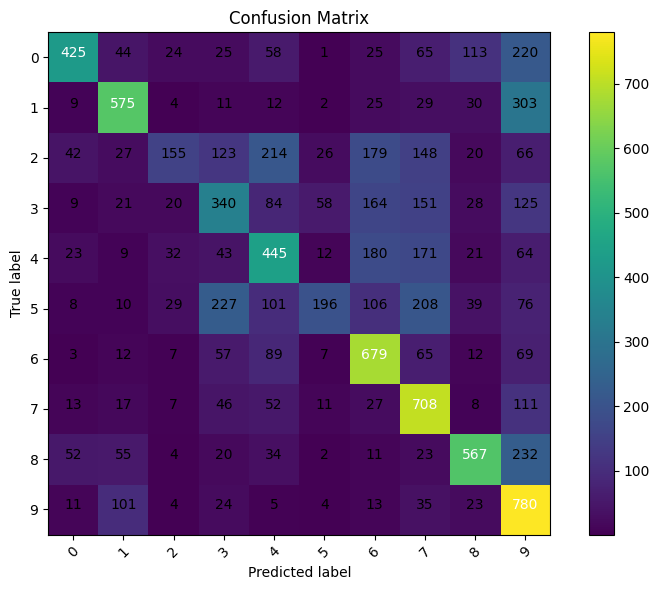

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=None)  # Keeps the original colormap
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels for axes
classes = [str(i) for i in range(10)]  # Assuming 10 classes labeled as 0, 1, ..., 9
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add values to cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [14]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
cnn.fit(x_train, y_train, epochs=10)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3808 - loss: 1.7040
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5869 - loss: 1.1766
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6461 - loss: 1.0073
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6767 - loss: 0.9240
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7073 - loss: 0.8551
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7280 - loss: 0.7938
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7411 - loss: 0.7494
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7526 - loss: 0.7141
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7668 - loss: 0.6721
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7798 - loss: 0.6339


In [17]:
cnn.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6915 - loss: 0.9156


[0.9135931730270386, 0.6934999823570251]

In [18]:
y_pred = cnn.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.71      0.74      1000
           1       0.78      0.81      0.80      1000
           2       0.51      0.65      0.57      1000
           3       0.51      0.51      0.51      1000
           4       0.68      0.58      0.63      1000
           5       0.62      0.60      0.61      1000
           6       0.74      0.80      0.77      1000
           7       0.76      0.76      0.76      1000
           8       0.79      0.81      0.80      1000
           9       0.85      0.69      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



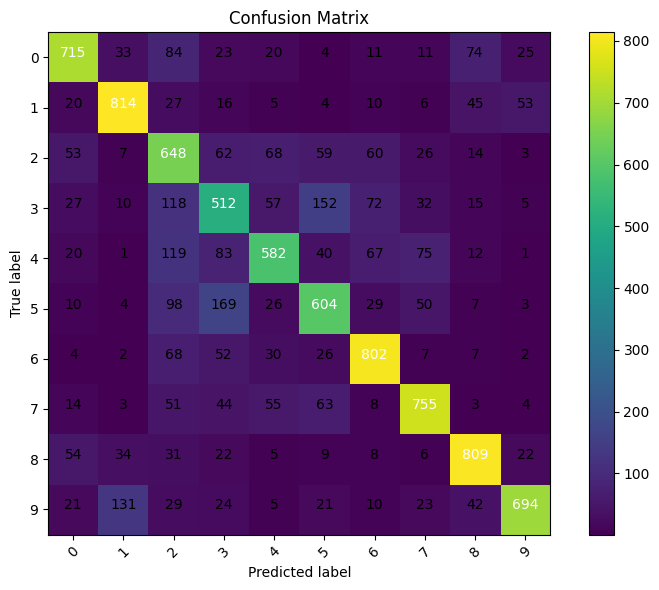

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=None)  # Keeps the original colormap
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels for axes
classes = [str(i) for i in range(10)]  # Assuming 10 classes labeled as 0, 1, ..., 9
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add values to cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [20]:
!nvidia-smi

Thu Dec  5 21:15:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              33W /  70W |   1415MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--